In [2]:
import torch
import gym
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class AgentConfig:
    # Learning
    gamma = 0.99
    plot_every = 5
    update_freq = 1
    k_epoch = 3
    learning_rate = 0.02
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01
    
    # Memory
    memory_size = 400

    train_cartpole = True

In [5]:
class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size=4):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3_pi = nn.Linear(24, self.action_size)
        self.fc3_v = nn.Linear(24, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x

In [6]:
def plot_graph(reward_history, avg_reward):
    df = pd.DataFrame({'x': range(len(reward_history)), 'Reward': reward_history, 'Average': avg_reward})
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')

    plt.plot(df['x'], df['Reward'], marker='', color=palette(1), linewidth=0.8, alpha=0.9, label='Reward')
    # plt.plot(df['x'], df['Average'], marker='', color='tomato', linewidth=1, alpha=0.9, label='Average')

    # plt.legend(loc='upper left')
    plt.title("CartPole", fontsize=14)
    plt.xlabel("episode", fontsize=12)
    plt.ylabel("score", fontsize=12)

In [12]:
class Agent(AgentConfig):
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.action_size = self.env.action_space.n  # 2 for cartpole
        if self.train_cartpole:
            self.policy_network = MlpPolicy(action_size=self.action_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.FloatTensor([])
        }

    def new_random_game(self):
        self.env.reset()
        action = self.env.action_space.sample()
        screen, reward, terminal, info = self.env.step(action)
        return screen, reward, action, terminal

    def train(self):
        episode = 0
        step = 0
        reward_history = []
        avg_reward = []
        solved = False

        # A new episode
        while not solved:
            start_step = step
            episode += 1
            episode_length = 0

            # Get initial state
            state, reward, action, terminal = self.new_random_game()
            current_state = state
            total_episode_reward = 1

            # A step in an episode
            while not solved:
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.pi(torch.FloatTensor(current_state).to(device))
                # print(prob_a)
                action = torch.distributions.Categorical(prob_a).sample().item()

                # Act
                state, reward, terminal, _ = self.env.step(action)
                new_state = state

                reward = -1 if terminal else reward

                self.add_memory(current_state, action, reward/10.0, new_state, terminal, prob_a[action].item())

                current_state = new_state
                total_episode_reward += reward

                if terminal:
                    episode_length = step - start_step
                    reward_history.append(total_episode_reward)
                    avg_reward.append(sum(reward_history[-10:])/10.0)

                    self.finish_path(episode_length)

                    if len(reward_history) > 100 and sum(reward_history[-100:-1]) / 100 >= 195:
                        solved = True

                    print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                          'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                                                    self.scheduler.get_lr()[0]))

                    self.env.reset()

                    break

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()

            if episode % self.plot_every == 0:
                plot_graph(reward_history, avg_reward)

        self.env.close()

    def update_network(self):
        # get ratio
        pi = self.policy_network.pi(torch.FloatTensor(self.memory['state']).to(device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action']))
        old_probs_a = torch.FloatTensor(self.memory['action_prob'])
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss
        surr1 = ratio * torch.FloatTensor(self.memory['advantage'])
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.FloatTensor(self.memory['advantage'])
        pred_v = self.policy_network.v(torch.FloatTensor(self.memory['state']).to(device))
        v_loss = 0.5 * (pred_v - self.memory['td_target']).pow(2)  # Huber loss
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy])
        self.loss = (-torch.min(surr1, surr2) + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]

        td_target = torch.FloatTensor(reward) + \
                    self.gamma * self.policy_network.v(torch.FloatTensor(next_state)) * torch.FloatTensor(terminal)
        delta = td_target - self.policy_network.v(torch.FloatTensor(state))
        delta = delta.detach().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'], td_target.data), dim=0)
        self.memory['advantage'] += advantages
            

episode: 1.00, total step: 56.00, last_episode length: 56.00, last_episode_reward: 55.00, loss: 0.0000, lr: 0.0200
episode: 2.00, total step: 103.00, last_episode length: 47.00, last_episode_reward: 46.00, loss: -1.1789, lr: 0.0200
episode: 3.00, total step: 143.00, last_episode length: 40.00, last_episode_reward: 39.00, loss: -1.1360, lr: 0.0199
episode: 4.00, total step: 181.00, last_episode length: 38.00, last_episode_reward: 37.00, loss: -1.0958, lr: 0.0199
episode: 5.00, total step: 224.00, last_episode length: 43.00, last_episode_reward: 42.00, loss: -1.0472, lr: 0.0199
episode: 6.00, total step: 237.00, last_episode length: 13.00, last_episode_reward: 12.00, loss: -1.0295, lr: 0.0199
episode: 7.00, total step: 266.00, last_episode length: 29.00, last_episode_reward: 28.00, loss: -0.9874, lr: 0.0199
episode: 8.00, total step: 277.00, last_episode length: 11.00, last_episode_reward: 10.00, loss: -0.9572, lr: 0.0198
episode: 9.00, total step: 295.00, last_episode length: 18.00, las

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 11.00, total step: 394.00, last_episode length: 44.00, last_episode_reward: 43.00, loss: -0.9218, lr: 0.0198
episode: 12.00, total step: 433.00, last_episode length: 39.00, last_episode_reward: 38.00, loss: -0.9225, lr: 0.0198
episode: 13.00, total step: 477.00, last_episode length: 44.00, last_episode_reward: 43.00, loss: -0.8633, lr: 0.0197
episode: 14.00, total step: 530.00, last_episode length: 53.00, last_episode_reward: 52.00, loss: -0.8496, lr: 0.0197
episode: 15.00, total step: 554.00, last_episode length: 24.00, last_episode_reward: 23.00, loss: -0.8391, lr: 0.0197
episode: 16.00, total step: 579.00, last_episode length: 25.00, last_episode_reward: 24.00, loss: -0.8218, lr: 0.0197
episode: 17.00, total step: 632.00, last_episode length: 53.00, last_episode_reward: 52.00, loss: -0.8126, lr: 0.0197
episode: 18.00, total step: 678.00, last_episode length: 46.00, last_episode_reward: 45.00, loss: -0.8331, lr: 0.0196
episode: 19.00, total step: 708.00, last_episode length

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 21.00, total step: 870.00, last_episode length: 71.00, last_episode_reward: 70.00, loss: -0.9256, lr: 0.0196
episode: 22.00, total step: 945.00, last_episode length: 75.00, last_episode_reward: 74.00, loss: -0.9497, lr: 0.0196
episode: 23.00, total step: 1023.00, last_episode length: 78.00, last_episode_reward: 77.00, loss: -0.9925, lr: 0.0195
episode: 24.00, total step: 1075.00, last_episode length: 52.00, last_episode_reward: 51.00, loss: -1.0464, lr: 0.0195


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 25.00, total step: 1140.00, last_episode length: 65.00, last_episode_reward: 64.00, loss: -1.0492, lr: 0.0195
episode: 26.00, total step: 1182.00, last_episode length: 42.00, last_episode_reward: 41.00, loss: -1.0420, lr: 0.0195
episode: 27.00, total step: 1296.00, last_episode length: 114.00, last_episode_reward: 113.00, loss: -0.9854, lr: 0.0195
episode: 28.00, total step: 1349.00, last_episode length: 53.00, last_episode_reward: 52.00, loss: -1.0228, lr: 0.0194
episode: 29.00, total step: 1447.00, last_episode length: 98.00, last_episode_reward: 97.00, loss: -1.0089, lr: 0.0194
episode: 30.00, total step: 1510.00, last_episode length: 63.00, last_episode_reward: 62.00, loss: -1.0016, lr: 0.0194
episode: 31.00, total step: 1586.00, last_episode length: 76.00, last_episode_reward: 75.00, loss: -0.9827, lr: 0.0194
episode: 32.00, total step: 1722.00, last_episode length: 136.00, last_episode_reward: 135.00, loss: -1.0345, lr: 0.0194


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 33.00, total step: 1893.00, last_episode length: 171.00, last_episode_reward: 170.00, loss: -1.0352, lr: 0.0194
episode: 34.00, total step: 1949.00, last_episode length: 56.00, last_episode_reward: 55.00, loss: -1.1472, lr: 0.0193
episode: 35.00, total step: 2047.00, last_episode length: 98.00, last_episode_reward: 97.00, loss: -1.1027, lr: 0.0193
episode: 36.00, total step: 2136.00, last_episode length: 89.00, last_episode_reward: 88.00, loss: -1.0888, lr: 0.0193
episode: 37.00, total step: 2237.00, last_episode length: 101.00, last_episode_reward: 100.00, loss: -1.0880, lr: 0.0193

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 38.00, total step: 2311.00, last_episode length: 74.00, last_episode_reward: 73.00, loss: -0.9774, lr: 0.0193
episode: 39.00, total step: 2424.00, last_episode length: 113.00, last_episode_reward: 112.00, loss: -0.9556, lr: 0.0192
episode: 40.00, total step: 2538.00, last_episode length: 114.00, last_episode_reward: 113.00, loss: -0.9579, lr: 0.0192


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 41.00, total step: 2666.00, last_episode length: 128.00, last_episode_reward: 127.00, loss: -1.0184, lr: 0.0192
episode: 42.00, total step: 2758.00, last_episode length: 92.00, last_episode_reward: 91.00, loss: -1.0296, lr: 0.0192
episode: 43.00, total step: 2844.00, last_episode length: 86.00, last_episode_reward: 85.00, loss: -1.0312, lr: 0.0192
episode: 44.00, total step: 2938.00, last_episode length: 94.00, last_episode_reward: 93.00, loss: -1.0271, lr: 0.0191
episode: 45.00, total step: 3014.00, last_episode length: 76.00, last_episode_reward: 75.00, loss: -1.0030, lr: 0.0191
episode: 46.00, total step: 3128.00, last_episode length: 114.00, last_episode_reward: 113.00, loss: -0.9094, lr: 0.0191
episode: 47.00, total step: 3213.00, last_episode length: 85.00, last_episode_reward: 84.00, loss: -0.9475, lr: 0.0191


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 48.00, total step: 3412.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9277, lr: 0.0191
episode: 49.00, total step: 3611.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0692, lr: 0.0190
episode: 50.00, total step: 3778.00, last_episode length: 167.00, last_episode_reward: 166.00, loss: -1.1641, lr: 0.0190


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 51.00, total step: 3977.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0910, lr: 0.0190
episode: 52.00, total step: 4176.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0458, lr: 0.0190
episode: 53.00, total step: 4291.00, last_episode length: 115.00, last_episode_reward: 114.00, loss: -1.0938, lr: 0.0190
episode: 54.00, total step: 4386.00, last_episode length: 95.00, last_episode_reward: 94.00, loss: -1.0386, lr: 0.0189
episode: 55.00, total step: 4585.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0934, lr: 0.0189
episode: 56.00, total step: 4784.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.1100, lr: 0.0189
episode: 57.00, total step: 4983.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.1048, lr: 0.0189

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 58.00, total step: 5182.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0922, lr: 0.0189
episode: 59.00, total step: 5381.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0934, lr: 0.0189
episode: 60.00, total step: 5580.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0861, lr: 0.0188
episode: 61.00, total step: 5779.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0724, lr: 0.0188
episode: 62.00, total step: 5978.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0298, lr: 0.0188


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 63.00, total step: 6177.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0158, lr: 0.0188
episode: 64.00, total step: 6376.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0238, lr: 0.0188
episode: 65.00, total step: 6575.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0250, lr: 0.0187


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 66.00, total step: 6685.00, last_episode length: 110.00, last_episode_reward: 109.00, loss: -1.0356, lr: 0.0187
episode: 67.00, total step: 6884.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0042, lr: 0.0187
episode: 68.00, total step: 7083.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0113, lr: 0.0187
episode: 69.00, total step: 7282.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0938, lr: 0.0187
episode: 70.00, total step: 7481.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0430, lr: 0.0186
episode: 71.00, total step: 7644.00, last_episode length: 163.00, last_episode_reward: 162.00, loss: -0.9835, lr: 0.0186


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 72.00, total step: 7843.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9160, lr: 0.0186
episode: 73.00, total step: 8042.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9087, lr: 0.0186
episode: 74.00, total step: 8241.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9905, lr: 0.0186
episode: 75.00, total step: 8399.00, last_episode length: 158.00, last_episode_reward: 157.00, loss: -0.9845, lr: 0.0186
episode: 76.00, total step: 8598.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9727, lr: 0.0185
episode: 77.00, total step: 8797.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9327, lr: 0.0185


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 78.00, total step: 8996.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9416, lr: 0.0185
episode: 79.00, total step: 9195.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9606, lr: 0.0185
episode: 80.00, total step: 9394.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9455, lr: 0.0185
episode: 81.00, total step: 9593.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9389, lr: 0.0184


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 82.00, total step: 9792.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9542, lr: 0.0184
episode: 83.00, total step: 9931.00, last_episode length: 139.00, last_episode_reward: 138.00, loss: -0.9148, lr: 0.0184
episode: 84.00, total step: 10069.00, last_episode length: 138.00, last_episode_reward: 137.00, loss: -0.8464, lr: 0.0184
episode: 85.00, total step: 10268.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9403, lr: 0.0184
episode: 86.00, total step: 10439.00, last_episode length: 171.00, last_episode_reward: 170.00, loss: -0.9495, lr: 0.0184
episode: 87.00, total step: 10638.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9032, lr: 0.0183


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 88.00, total step: 10837.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8183, lr: 0.0183
episode: 89.00, total step: 11008.00, last_episode length: 171.00, last_episode_reward: 170.00, loss: -0.8971, lr: 0.0183
episode: 90.00, total step: 11207.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8269, lr: 0.0183


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 91.00, total step: 11406.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7733, lr: 0.0183
episode: 92.00, total step: 11602.00, last_episode length: 196.00, last_episode_reward: 195.00, loss: -0.8249, lr: 0.0182
episode: 93.00, total step: 11801.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9044, lr: 0.0182
episode: 94.00, total step: 12000.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9279, lr: 0.0182
episode: 95.00, total step: 12199.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8686, lr: 0.0182


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 96.00, total step: 12398.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8406, lr: 0.0182
episode: 97.00, total step: 12532.00, last_episode length: 134.00, last_episode_reward: 133.00, loss: -0.8238, lr: 0.0182
episode: 98.00, total step: 12731.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7529, lr: 0.0181
episode: 99.00, total step: 12885.00, last_episode length: 154.00, last_episode_reward: 153.00, loss: -0.7111, lr: 0.0181
episode: 100.00, total step: 13084.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7829, lr: 0.0181
episode: 101.00, total step: 13237.00, last_episode length: 153.00, last_episode_reward: 152.00, loss: -0.7378, lr: 0.0181
episode: 102.00, total step: 13436.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7796, lr: 0.0181


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 103.00, total step: 13635.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7288, lr: 0.0180
episode: 104.00, total step: 13815.00, last_episode length: 180.00, last_episode_reward: 179.00, loss: -0.8455, lr: 0.0180
episode: 105.00, total step: 13994.00, last_episode length: 179.00, last_episode_reward: 178.00, loss: -0.7926, lr: 0.0180


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 106.00, total step: 14193.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8042, lr: 0.0180
episode: 107.00, total step: 14360.00, last_episode length: 167.00, last_episode_reward: 166.00, loss: -0.7165, lr: 0.0180
episode: 108.00, total step: 14559.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7133, lr: 0.0180
episode: 109.00, total step: 14758.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6760, lr: 0.0179
episode: 110.00, total step: 14957.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7450, lr: 0.0179
episode: 111.00, total step: 15156.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7117, lr: 0.0179


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 112.00, total step: 15355.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7061, lr: 0.0179
episode: 113.00, total step: 15498.00, last_episode length: 143.00, last_episode_reward: 142.00, loss: -0.7659, lr: 0.0179
episode: 114.00, total step: 15697.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6939, lr: 0.0178
episode: 115.00, total step: 15855.00, last_episode length: 158.00, last_episode_reward: 157.00, loss: -0.7132, lr: 0.0178
episode: 116.00, total step: 16021.00, last_episode length: 166.00, last_episode_reward: 165.00, loss: -0.7259, lr: 0.0178
episode: 117.00, total step: 16220.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7074, lr: 0.0178


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 118.00, total step: 16419.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7420, lr: 0.0178
episode: 119.00, total step: 16557.00, last_episode length: 138.00, last_episode_reward: 137.00, loss: -0.6613, lr: 0.0178
episode: 120.00, total step: 16756.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5940, lr: 0.0177


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 121.00, total step: 16955.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5961, lr: 0.0177
episode: 122.00, total step: 17154.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7507, lr: 0.0177
episode: 123.00, total step: 17353.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6806, lr: 0.0177
episode: 124.00, total step: 17552.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6029, lr: 0.0177
episode: 125.00, total step: 17751.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6221, lr: 0.0176
episode: 126.00, total step: 17950.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6106, lr: 0.0176


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 127.00, total step: 18116.00, last_episode length: 166.00, last_episode_reward: 165.00, loss: -0.6031, lr: 0.0176
episode: 128.00, total step: 18315.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5533, lr: 0.0176
episode: 129.00, total step: 18514.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5317, lr: 0.0176
episode: 130.00, total step: 18713.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6028, lr: 0.0176
episode: 131.00, total step: 18850.00, last_episode length: 137.00, last_episode_reward: 136.00, loss: -0.5705, lr: 0.0175
episode: 132.00, total step: 19049.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4921, lr: 0.0175


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 133.00, total step: 19248.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4455, lr: 0.0175
episode: 134.00, total step: 19447.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5270, lr: 0.0175
episode: 135.00, total step: 19646.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5335, lr: 0.0175


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 136.00, total step: 19844.00, last_episode length: 198.00, last_episode_reward: 197.00, loss: -0.6202, lr: 0.0175
episode: 137.00, total step: 20043.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7529, lr: 0.0174
episode: 138.00, total step: 20242.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6997, lr: 0.0174
episode: 139.00, total step: 20441.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5473, lr: 0.0174
episode: 140.00, total step: 20640.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4887, lr: 0.0174
episode: 141.00, total step: 20839.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4933, lr: 0.0174


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 142.00, total step: 21038.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5411, lr: 0.0174
episode: 143.00, total step: 21180.00, last_episode length: 142.00, last_episode_reward: 141.00, loss: -0.5391, lr: 0.0173
episode: 144.00, total step: 21339.00, last_episode length: 159.00, last_episode_reward: 158.00, loss: -0.4927, lr: 0.0173
episode: 145.00, total step: 21538.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5816, lr: 0.0173
episode: 146.00, total step: 21737.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7449, lr: 0.0173
episode: 147.00, total step: 21936.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8010, lr: 0.0173

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 148.00, total step: 22135.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6676, lr: 0.0172
episode: 149.00, total step: 22334.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6063, lr: 0.0172
episode: 150.00, total step: 22533.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2440, lr: 0.0172


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 151.00, total step: 22732.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1715, lr: 0.0172
episode: 152.00, total step: 22931.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4932, lr: 0.0172
episode: 153.00, total step: 23130.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4068, lr: 0.0172
episode: 154.00, total step: 23329.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3651, lr: 0.0171
episode: 155.00, total step: 23528.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3705, lr: 0.0171


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 156.00, total step: 23727.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4229, lr: 0.0171
episode: 157.00, total step: 23926.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4336, lr: 0.0171
episode: 158.00, total step: 24125.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4018, lr: 0.0171
episode: 159.00, total step: 24252.00, last_episode length: 127.00, last_episode_reward: 126.00, loss: -0.3216, lr: 0.0171
episode: 160.00, total step: 24451.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2478, lr: 0.0170
episode: 161.00, total step: 24650.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3192, lr: 0.0170


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 162.00, total step: 24849.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4448, lr: 0.0170
episode: 163.00, total step: 25048.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3910, lr: 0.0170
episode: 164.00, total step: 25247.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3736, lr: 0.0170
episode: 165.00, total step: 25446.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3762, lr: 0.0170


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 166.00, total step: 25645.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5162, lr: 0.0169
episode: 167.00, total step: 25844.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5874, lr: 0.0169
episode: 168.00, total step: 26043.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5027, lr: 0.0169
episode: 169.00, total step: 26179.00, last_episode length: 136.00, last_episode_reward: 135.00, loss: -0.5450, lr: 0.0169
episode: 170.00, total step: 26378.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4495, lr: 0.0169
episode: 171.00, total step: 26577.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5156, lr: 0.0169
episode: 172.00, total step: 26776.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3752, lr: 0.0168

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 173.00, total step: 26884.00, last_episode length: 108.00, last_episode_reward: 107.00, loss: -0.3045, lr: 0.0168
episode: 174.00, total step: 27083.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2300, lr: 0.0168
episode: 175.00, total step: 27282.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3041, lr: 0.0168
episode: 176.00, total step: 27481.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3915, lr: 0.0168
episode: 177.00, total step: 27680.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3582, lr: 0.0168


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 178.00, total step: 27879.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3320, lr: 0.0167
episode: 179.00, total step: 28078.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3062, lr: 0.0167
episode: 180.00, total step: 28277.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3616, lr: 0.0167


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 181.00, total step: 28476.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3331, lr: 0.0167
episode: 182.00, total step: 28675.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.2685, lr: 0.0167
episode: 183.00, total step: 28874.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0857, lr: 0.0167
episode: 184.00, total step: 29073.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4255, lr: 0.0166
episode: 185.00, total step: 29272.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3249, lr: 0.0166
episode: 186.00, total step: 29471.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3685, lr: 0.0166


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 187.00, total step: 29670.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5914, lr: 0.0166
episode: 188.00, total step: 29869.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5533, lr: 0.0166
episode: 189.00, total step: 29981.00, last_episode length: 112.00, last_episode_reward: 111.00, loss: -0.3459, lr: 0.0166
episode: 190.00, total step: 30180.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2421, lr: 0.0165
episode: 191.00, total step: 30303.00, last_episode length: 123.00, last_episode_reward: 122.00, loss: -0.1751, lr: 0.0165
episode: 192.00, total step: 30486.00, last_episode length: 183.00, last_episode_reward: 182.00, loss: -0.3376, lr: 0.0165


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 193.00, total step: 30685.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3389, lr: 0.0165
episode: 194.00, total step: 30884.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5338, lr: 0.0165
episode: 195.00, total step: 31013.00, last_episode length: 129.00, last_episode_reward: 128.00, loss: -0.3856, lr: 0.0165


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 196.00, total step: 31212.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2784, lr: 0.0164
episode: 197.00, total step: 31411.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2869, lr: 0.0164
episode: 198.00, total step: 31610.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3867, lr: 0.0164
episode: 199.00, total step: 31809.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2057, lr: 0.0164
episode: 200.00, total step: 32008.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1606, lr: 0.0164
episode: 201.00, total step: 32207.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1954, lr: 0.0164


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 202.00, total step: 32406.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4137, lr: 0.0163
episode: 203.00, total step: 32605.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4145, lr: 0.0163
episode: 204.00, total step: 32744.00, last_episode length: 139.00, last_episode_reward: 138.00, loss: -0.1995, lr: 0.0163
episode: 205.00, total step: 32943.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1076, lr: 0.0163
episode: 206.00, total step: 33142.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2135, lr: 0.0163
episode: 207.00, total step: 33341.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5368, lr: 0.0163


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 208.00, total step: 33540.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4454, lr: 0.0162
episode: 209.00, total step: 33739.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2517, lr: 0.0162
episode: 210.00, total step: 33938.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3281, lr: 0.0162
episode: 211.00, total step: 34137.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3333, lr: 0.0162


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 212.00, total step: 34336.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2358, lr: 0.0162
episode: 213.00, total step: 34535.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2136, lr: 0.0162
episode: 214.00, total step: 34734.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2351, lr: 0.0161
episode: 215.00, total step: 34933.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4061, lr: 0.0161
episode: 216.00, total step: 35132.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3956, lr: 0.0161


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 217.00, total step: 35261.00, last_episode length: 129.00, last_episode_reward: 128.00, loss: -0.4441, lr: 0.0161
episode: 218.00, total step: 35460.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3891, lr: 0.0161
episode: 219.00, total step: 35659.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6337, lr: 0.0161
episode: 220.00, total step: 35858.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6657, lr: 0.0160
episode: 221.00, total step: 36057.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4799, lr: 0.0160
episode: 222.00, total step: 36256.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4458, lr: 0.0160


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 223.00, total step: 36455.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4377, lr: 0.0160
episode: 224.00, total step: 36654.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2928, lr: 0.0160
episode: 225.00, total step: 36800.00, last_episode length: 146.00, last_episode_reward: 145.00, loss: -0.2530, lr: 0.0160
episode: 226.00, total step: 36999.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3208, lr: 0.0160
episode: 227.00, total step: 37198.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5168, lr: 0.0159


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 228.00, total step: 37381.00, last_episode length: 183.00, last_episode_reward: 182.00, loss: -0.4638, lr: 0.0159
episode: 229.00, total step: 37536.00, last_episode length: 155.00, last_episode_reward: 154.00, loss: -0.4681, lr: 0.0159
episode: 230.00, total step: 37735.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4553, lr: 0.0159


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 231.00, total step: 37934.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8338, lr: 0.0159
episode: 232.00, total step: 38133.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5882, lr: 0.0159
episode: 233.00, total step: 38332.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4532, lr: 0.0158
episode: 234.00, total step: 38531.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4294, lr: 0.0158
episode: 235.00, total step: 38730.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2680, lr: 0.0158
episode: 236.00, total step: 38840.00, last_episode length: 110.00, last_episode_reward: 109.00, loss: -0.1850, lr: 0.0158


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 237.00, total step: 39039.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1557, lr: 0.0158
episode: 238.00, total step: 39223.00, last_episode length: 184.00, last_episode_reward: 183.00, loss: -0.3075, lr: 0.0158
episode: 239.00, total step: 39378.00, last_episode length: 155.00, last_episode_reward: 154.00, loss: -0.6483, lr: 0.0157
episode: 240.00, total step: 39577.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5630, lr: 0.0157


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 241.00, total step: 39776.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4887, lr: 0.0157
episode: 242.00, total step: 39975.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3158, lr: 0.0157
episode: 243.00, total step: 40174.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4381, lr: 0.0157
episode: 244.00, total step: 40373.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4807, lr: 0.0157
episode: 245.00, total step: 40572.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3206, lr: 0.0157
episode: 246.00, total step: 40771.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1908, lr: 0.0156


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 247.00, total step: 40970.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3363, lr: 0.0156
episode: 248.00, total step: 41072.00, last_episode length: 102.00, last_episode_reward: 101.00, loss: -0.3560, lr: 0.0156
episode: 249.00, total step: 41271.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3120, lr: 0.0156
episode: 250.00, total step: 41435.00, last_episode length: 164.00, last_episode_reward: 163.00, loss: -0.3648, lr: 0.0156
episode: 251.00, total step: 41613.00, last_episode length: 178.00, last_episode_reward: 177.00, loss: -0.6639, lr: 0.0156
episode: 252.00, total step: 41812.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6916, lr: 0.0155


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 253.00, total step: 42011.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4412, lr: 0.0155
episode: 254.00, total step: 42210.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1463, lr: 0.0155
episode: 255.00, total step: 42409.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.0038, lr: 0.0155


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 256.00, total step: 42608.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1152, lr: 0.0155
episode: 257.00, total step: 42807.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3587, lr: 0.0155
episode: 258.00, total step: 43006.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5679, lr: 0.0154
episode: 259.00, total step: 43133.00, last_episode length: 127.00, last_episode_reward: 126.00, loss: -0.3879, lr: 0.0154
episode: 260.00, total step: 43332.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4034, lr: 0.0154


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 261.00, total step: 43531.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1664, lr: 0.0154
episode: 262.00, total step: 43730.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1715, lr: 0.0154
episode: 263.00, total step: 43929.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1135, lr: 0.0154
episode: 264.00, total step: 44017.00, last_episode length: 88.00, last_episode_reward: 87.00, loss: -0.4560, lr: 0.0154
episode: 265.00, total step: 44216.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4595, lr: 0.0153


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 266.00, total step: 44415.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6425, lr: 0.0153
episode: 267.00, total step: 44510.00, last_episode length: 95.00, last_episode_reward: 94.00, loss: -0.4363, lr: 0.0153
episode: 268.00, total step: 44709.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4192, lr: 0.0153
episode: 269.00, total step: 44844.00, last_episode length: 135.00, last_episode_reward: 134.00, loss: -0.1324, lr: 0.0153
episode: 270.00, total step: 45043.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3632, lr: 0.0153
episode: 271.00, total step: 45242.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2866, lr: 0.0153


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 272.00, total step: 45400.00, last_episode length: 158.00, last_episode_reward: 157.00, loss: -0.3859, lr: 0.0152
episode: 273.00, total step: 45599.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4342, lr: 0.0152
episode: 274.00, total step: 45718.00, last_episode length: 119.00, last_episode_reward: 118.00, loss: -0.3626, lr: 0.0152
episode: 275.00, total step: 45917.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5142, lr: 0.0152
episode: 276.00, total step: 46116.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5278, lr: 0.0152
episode: 277.00, total step: 46239.00, last_episode length: 123.00, last_episode_reward: 122.00, loss: -0.3769, lr: 0.0152


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 278.00, total step: 46438.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4182, lr: 0.0151
episode: 279.00, total step: 46637.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4094, lr: 0.0151
episode: 280.00, total step: 46836.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5316, lr: 0.0151


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 281.00, total step: 47035.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2570, lr: 0.0151
episode: 282.00, total step: 47234.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2870, lr: 0.0151
episode: 283.00, total step: 47433.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1971, lr: 0.0151
episode: 284.00, total step: 47632.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1325, lr: 0.0151
episode: 285.00, total step: 47831.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0702, lr: 0.0150


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 286.00, total step: 48030.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2716, lr: 0.0150
episode: 287.00, total step: 48150.00, last_episode length: 120.00, last_episode_reward: 119.00, loss: -0.5583, lr: 0.0150
episode: 288.00, total step: 48349.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6451, lr: 0.0150
episode: 289.00, total step: 48464.00, last_episode length: 115.00, last_episode_reward: 114.00, loss: -0.3132, lr: 0.0150
episode: 290.00, total step: 48663.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3341, lr: 0.0150
episode: 291.00, total step: 48762.00, last_episode length: 99.00, last_episode_reward: 98.00, loss: -0.3051, lr: 0.0149
episode: 292.00, total step: 48873.00, last_episode length: 111.00, last_episode_reward: 110.00, loss: -0.6243, lr: 0.0149
episode: 293.00, total step: 49070.00, last_episode length: 197.00, last_episode_reward: 196.00, loss: -0.6243, lr: 0.0149

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 294.00, total step: 49269.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5658, lr: 0.0149
episode: 295.00, total step: 49468.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5781, lr: 0.0149
episode: 296.00, total step: 49605.00, last_episode length: 137.00, last_episode_reward: 136.00, loss: -0.0383, lr: 0.0149
episode: 297.00, total step: 49804.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0035, lr: 0.0149


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 298.00, total step: 50003.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0631, lr: 0.0148
episode: 299.00, total step: 50202.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4522, lr: 0.0148
episode: 300.00, total step: 50401.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3797, lr: 0.0148


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 301.00, total step: 50600.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7153, lr: 0.0148
episode: 302.00, total step: 50799.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7937, lr: 0.0148
episode: 303.00, total step: 50998.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4018, lr: 0.0148
episode: 304.00, total step: 51107.00, last_episode length: 109.00, last_episode_reward: 108.00, loss: -0.2529, lr: 0.0148
episode: 305.00, total step: 51306.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1985, lr: 0.0147
episode: 306.00, total step: 51505.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5059, lr: 0.0147


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 307.00, total step: 51704.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4398, lr: 0.0147
episode: 308.00, total step: 51903.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4569, lr: 0.0147
episode: 309.00, total step: 52094.00, last_episode length: 191.00, last_episode_reward: 190.00, loss: -0.4318, lr: 0.0147
episode: 310.00, total step: 52293.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4749, lr: 0.0147
episode: 311.00, total step: 52492.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3536, lr: 0.0147
episode: 312.00, total step: 52691.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1425, lr: 0.0146


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 313.00, total step: 52890.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2600, lr: 0.0146
episode: 314.00, total step: 53089.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6250, lr: 0.0146
episode: 315.00, total step: 53215.00, last_episode length: 126.00, last_episode_reward: 125.00, loss: -0.4830, lr: 0.0146


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 316.00, total step: 53414.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4877, lr: 0.0146
episode: 317.00, total step: 53613.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3070, lr: 0.0146
episode: 318.00, total step: 53812.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3298, lr: 0.0145
episode: 319.00, total step: 54011.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0674, lr: 0.0145
episode: 320.00, total step: 54210.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1330, lr: 0.0145
episode: 321.00, total step: 54374.00, last_episode length: 164.00, last_episode_reward: 163.00, loss: -0.2795, lr: 0.0145


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 322.00, total step: 54573.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2917, lr: 0.0145
episode: 323.00, total step: 54772.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5157, lr: 0.0145
episode: 324.00, total step: 54923.00, last_episode length: 151.00, last_episode_reward: 150.00, loss: -0.4040, lr: 0.0145
episode: 325.00, total step: 55122.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4323, lr: 0.0144
episode: 326.00, total step: 55321.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3595, lr: 0.0144
episode: 327.00, total step: 55520.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4616, lr: 0.0144


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 328.00, total step: 55719.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2177, lr: 0.0144
episode: 329.00, total step: 55918.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0651, lr: 0.0144
episode: 330.00, total step: 56117.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.0162, lr: 0.0144
episode: 331.00, total step: 56316.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0348, lr: 0.0144
episode: 332.00, total step: 56515.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0138, lr: 0.0143

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 333.00, total step: 56690.00, last_episode length: 175.00, last_episode_reward: 174.00, loss: -0.4633, lr: 0.0143
episode: 334.00, total step: 56889.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5652, lr: 0.0143
episode: 335.00, total step: 57088.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5784, lr: 0.0143
episode: 336.00, total step: 57211.00, last_episode length: 123.00, last_episode_reward: 122.00, loss: -0.5331, lr: 0.0143
episode: 337.00, total step: 57410.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5182, lr: 0.0143

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 338.00, total step: 57609.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6965, lr: 0.0143
episode: 339.00, total step: 57808.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5113, lr: 0.0142
episode: 340.00, total step: 58007.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2938, lr: 0.0142
episode: 341.00, total step: 58206.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6118, lr: 0.0142
episode: 342.00, total step: 58405.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6241, lr: 0.0142


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 343.00, total step: 58604.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2977, lr: 0.0142
episode: 344.00, total step: 58803.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3705, lr: 0.0142
episode: 345.00, total step: 59002.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2785, lr: 0.0142


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 346.00, total step: 59201.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1874, lr: 0.0141
episode: 347.00, total step: 59400.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1040, lr: 0.0141
episode: 348.00, total step: 59599.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1181, lr: 0.0141
episode: 349.00, total step: 59798.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5356, lr: 0.0141
episode: 350.00, total step: 59952.00, last_episode length: 154.00, last_episode_reward: 153.00, loss: -0.8558, lr: 0.0141
episode: 351.00, total step: 60151.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7949, lr: 0.0141


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 352.00, total step: 60350.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5050, lr: 0.0141
episode: 353.00, total step: 60549.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6329, lr: 0.0140
episode: 354.00, total step: 60748.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5018, lr: 0.0140
episode: 355.00, total step: 60947.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.0197, lr: 0.0140
episode: 356.00, total step: 61146.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4046, lr: 0.0140
episode: 357.00, total step: 61345.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7791, lr: 0.0140

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 358.00, total step: 61544.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1917, lr: 0.0140
episode: 359.00, total step: 61668.00, last_episode length: 124.00, last_episode_reward: 123.00, loss: 0.6211, lr: 0.0140
episode: 360.00, total step: 61810.00, last_episode length: 142.00, last_episode_reward: 141.00, loss: -0.2326, lr: 0.0140
episode: 361.00, total step: 62009.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3378, lr: 0.0139
episode: 362.00, total step: 62136.00, last_episode length: 127.00, last_episode_reward: 126.00, loss: -0.7041, lr: 0.0139

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 363.00, total step: 62335.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7096, lr: 0.0139
episode: 364.00, total step: 62534.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6935, lr: 0.0139
episode: 365.00, total step: 62688.00, last_episode length: 154.00, last_episode_reward: 153.00, loss: -0.8301, lr: 0.0139


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 366.00, total step: 62887.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7927, lr: 0.0139
episode: 367.00, total step: 63086.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7897, lr: 0.0139
episode: 368.00, total step: 63285.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8278, lr: 0.0138
episode: 369.00, total step: 63484.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5392, lr: 0.0138
episode: 370.00, total step: 63623.00, last_episode length: 139.00, last_episode_reward: 138.00, loss: -0.4067, lr: 0.0138
episode: 371.00, total step: 63822.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3810, lr: 0.0138


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 372.00, total step: 64021.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4926, lr: 0.0138
episode: 373.00, total step: 64220.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6192, lr: 0.0138
episode: 374.00, total step: 64419.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5882, lr: 0.0138
episode: 375.00, total step: 64618.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4206, lr: 0.0137
episode: 376.00, total step: 64817.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2487, lr: 0.0137
episode: 377.00, total step: 65016.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2744, lr: 0.0137

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 378.00, total step: 65215.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4687, lr: 0.0137
episode: 379.00, total step: 65414.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3597, lr: 0.0137
episode: 380.00, total step: 65613.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1140, lr: 0.0137


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 381.00, total step: 65812.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3919, lr: 0.0137
episode: 382.00, total step: 66011.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7736, lr: 0.0136
episode: 383.00, total step: 66210.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6555, lr: 0.0136
episode: 384.00, total step: 66409.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2848, lr: 0.0136
episode: 385.00, total step: 66608.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3891, lr: 0.0136


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 386.00, total step: 66807.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3440, lr: 0.0136
episode: 387.00, total step: 67006.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0936, lr: 0.0136
episode: 388.00, total step: 67205.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3250, lr: 0.0136
episode: 389.00, total step: 67404.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4636, lr: 0.0136
episode: 390.00, total step: 67603.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2176, lr: 0.0135
episode: 391.00, total step: 67757.00, last_episode length: 154.00, last_episode_reward: 153.00, loss: -0.0913, lr: 0.0135


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 392.00, total step: 67956.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2289, lr: 0.0135
episode: 393.00, total step: 68155.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3183, lr: 0.0135
episode: 394.00, total step: 68354.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2119, lr: 0.0135
episode: 395.00, total step: 68536.00, last_episode length: 182.00, last_episode_reward: 181.00, loss: -0.1638, lr: 0.0135
episode: 396.00, total step: 68735.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3248, lr: 0.0135


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 397.00, total step: 68934.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6062, lr: 0.0134
episode: 398.00, total step: 69133.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4242, lr: 0.0134
episode: 399.00, total step: 69265.00, last_episode length: 132.00, last_episode_reward: 131.00, loss: -0.2234, lr: 0.0134
episode: 400.00, total step: 69464.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2636, lr: 0.0134
episode: 401.00, total step: 69663.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2314, lr: 0.0134
episode: 402.00, total step: 69813.00, last_episode length: 150.00, last_episode_reward: 149.00, loss: -0.1674, lr: 0.0134


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 403.00, total step: 69957.00, last_episode length: 144.00, last_episode_reward: 143.00, loss: -0.2238, lr: 0.0134
episode: 404.00, total step: 70156.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5447, lr: 0.0134
episode: 405.00, total step: 70355.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6623, lr: 0.0133


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 406.00, total step: 70554.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5182, lr: 0.0133
episode: 407.00, total step: 70680.00, last_episode length: 126.00, last_episode_reward: 125.00, loss: -0.4883, lr: 0.0133
episode: 408.00, total step: 70879.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5506, lr: 0.0133
episode: 409.00, total step: 71078.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6400, lr: 0.0133
episode: 410.00, total step: 71277.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2273, lr: 0.0133
episode: 411.00, total step: 71476.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1591, lr: 0.0133


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 412.00, total step: 71675.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4439, lr: 0.0132
episode: 413.00, total step: 71874.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4574, lr: 0.0132
episode: 414.00, total step: 72014.00, last_episode length: 140.00, last_episode_reward: 139.00, loss: -0.3033, lr: 0.0132
episode: 415.00, total step: 72213.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2926, lr: 0.0132
episode: 416.00, total step: 72351.00, last_episode length: 138.00, last_episode_reward: 137.00, loss: -0.3974, lr: 0.0132
episode: 417.00, total step: 72544.00, last_episode length: 193.00, last_episode_reward: 192.00, loss: -0.5994, lr: 0.0132


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 418.00, total step: 72743.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6522, lr: 0.0132
episode: 419.00, total step: 72942.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5905, lr: 0.0132
episode: 420.00, total step: 73141.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5783, lr: 0.0131


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 421.00, total step: 73340.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4888, lr: 0.0131
episode: 422.00, total step: 73539.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5487, lr: 0.0131
episode: 423.00, total step: 73738.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3445, lr: 0.0131
episode: 424.00, total step: 73937.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3125, lr: 0.0131
episode: 425.00, total step: 74136.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3540, lr: 0.0131
episode: 426.00, total step: 74335.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4007, lr: 0.0131


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 427.00, total step: 74534.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4082, lr: 0.0130
episode: 428.00, total step: 74733.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1353, lr: 0.0130
episode: 429.00, total step: 74932.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1593, lr: 0.0130
episode: 430.00, total step: 75131.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3163, lr: 0.0130
episode: 431.00, total step: 75330.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2326, lr: 0.0130
episode: 432.00, total step: 75529.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2200, lr: 0.0130


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 433.00, total step: 75728.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2043, lr: 0.0130
episode: 434.00, total step: 75927.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1552, lr: 0.0130
episode: 435.00, total step: 76126.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3491, lr: 0.0129


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 436.00, total step: 76325.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4465, lr: 0.0129
episode: 437.00, total step: 76524.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2177, lr: 0.0129
episode: 438.00, total step: 76723.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2610, lr: 0.0129
episode: 439.00, total step: 76922.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4992, lr: 0.0129
episode: 440.00, total step: 77121.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5750, lr: 0.0129


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 441.00, total step: 77320.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4398, lr: 0.0129
episode: 442.00, total step: 77519.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3214, lr: 0.0129
episode: 443.00, total step: 77718.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4411, lr: 0.0128
episode: 444.00, total step: 77856.00, last_episode length: 138.00, last_episode_reward: 137.00, loss: -0.6037, lr: 0.0128
episode: 445.00, total step: 78055.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6976, lr: 0.0128
episode: 446.00, total step: 78254.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2887, lr: 0.0128


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 447.00, total step: 78453.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1724, lr: 0.0128
episode: 448.00, total step: 78652.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2269, lr: 0.0128
episode: 449.00, total step: 78851.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1527, lr: 0.0128
episode: 450.00, total step: 79050.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3908, lr: 0.0127
episode: 451.00, total step: 79249.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4024, lr: 0.0127
episode: 452.00, total step: 79425.00, last_episode length: 176.00, last_episode_reward: 175.00, loss: -0.1968, lr: 0.0127


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 453.00, total step: 79624.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3345, lr: 0.0127
episode: 454.00, total step: 79823.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3153, lr: 0.0127
episode: 455.00, total step: 80007.00, last_episode length: 184.00, last_episode_reward: 183.00, loss: -0.5746, lr: 0.0127


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 456.00, total step: 80206.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7130, lr: 0.0127
episode: 457.00, total step: 80405.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4922, lr: 0.0127
episode: 458.00, total step: 80604.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2056, lr: 0.0126
episode: 459.00, total step: 80803.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3315, lr: 0.0126
episode: 460.00, total step: 80967.00, last_episode length: 164.00, last_episode_reward: 163.00, loss: -0.3080, lr: 0.0126
episode: 461.00, total step: 81130.00, last_episode length: 163.00, last_episode_reward: 162.00, loss: -0.3873, lr: 0.0126


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 462.00, total step: 81274.00, last_episode length: 144.00, last_episode_reward: 143.00, loss: -0.5964, lr: 0.0126
episode: 463.00, total step: 81473.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8393, lr: 0.0126
episode: 464.00, total step: 81672.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5460, lr: 0.0126
episode: 465.00, total step: 81843.00, last_episode length: 171.00, last_episode_reward: 170.00, loss: -0.4566, lr: 0.0126
episode: 466.00, total step: 82042.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5251, lr: 0.0125
episode: 467.00, total step: 82241.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6408, lr: 0.0125

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 468.00, total step: 82440.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4231, lr: 0.0125
episode: 469.00, total step: 82639.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1076, lr: 0.0125
episode: 470.00, total step: 82838.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2305, lr: 0.0125
episode: 471.00, total step: 83037.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4147, lr: 0.0125
episode: 472.00, total step: 83236.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3957, lr: 0.0125


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 473.00, total step: 83435.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5573, lr: 0.0125
episode: 474.00, total step: 83634.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4626, lr: 0.0124
episode: 475.00, total step: 83816.00, last_episode length: 182.00, last_episode_reward: 181.00, loss: -0.3554, lr: 0.0124


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 476.00, total step: 84015.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5008, lr: 0.0124
episode: 477.00, total step: 84214.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6507, lr: 0.0124
episode: 478.00, total step: 84413.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5661, lr: 0.0124
episode: 479.00, total step: 84612.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5976, lr: 0.0124
episode: 480.00, total step: 84811.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5533, lr: 0.0124
episode: 481.00, total step: 85010.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3497, lr: 0.0124


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 482.00, total step: 85209.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4500, lr: 0.0123
episode: 483.00, total step: 85368.00, last_episode length: 159.00, last_episode_reward: 158.00, loss: -0.6749, lr: 0.0123
episode: 484.00, total step: 85567.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7085, lr: 0.0123
episode: 485.00, total step: 85766.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5010, lr: 0.0123
episode: 486.00, total step: 85965.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3485, lr: 0.0123
episode: 487.00, total step: 86164.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2443, lr: 0.0123


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 488.00, total step: 86363.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4286, lr: 0.0123
episode: 489.00, total step: 86562.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4506, lr: 0.0123
episode: 490.00, total step: 86761.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5254, lr: 0.0122


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 491.00, total step: 86960.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6792, lr: 0.0122
episode: 492.00, total step: 87159.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6806, lr: 0.0122
episode: 493.00, total step: 87344.00, last_episode length: 185.00, last_episode_reward: 184.00, loss: -0.7465, lr: 0.0122
episode: 494.00, total step: 87543.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7415, lr: 0.0122
episode: 495.00, total step: 87742.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5380, lr: 0.0122
episode: 496.00, total step: 87941.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2641, lr: 0.0122


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 497.00, total step: 88140.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1955, lr: 0.0122
episode: 498.00, total step: 88339.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1460, lr: 0.0122
episode: 499.00, total step: 88538.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2418, lr: 0.0121
episode: 500.00, total step: 88737.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3330, lr: 0.0121
episode: 501.00, total step: 88936.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4976, lr: 0.0121


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 502.00, total step: 89135.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4527, lr: 0.0121
episode: 503.00, total step: 89334.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4157, lr: 0.0121
episode: 504.00, total step: 89533.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3355, lr: 0.0121
episode: 505.00, total step: 89732.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3213, lr: 0.0121
episode: 506.00, total step: 89931.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6165, lr: 0.0121
episode: 507.00, total step: 90130.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6194, lr: 0.0120


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 508.00, total step: 90329.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6372, lr: 0.0120
episode: 509.00, total step: 90528.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6550, lr: 0.0120
episode: 510.00, total step: 90727.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5114, lr: 0.0120


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 511.00, total step: 90900.00, last_episode length: 173.00, last_episode_reward: 172.00, loss: -0.5985, lr: 0.0120
episode: 512.00, total step: 91099.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6197, lr: 0.0120
episode: 513.00, total step: 91298.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5060, lr: 0.0120
episode: 514.00, total step: 91497.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3956, lr: 0.0120
episode: 515.00, total step: 91696.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5062, lr: 0.0119


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 516.00, total step: 91895.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4450, lr: 0.0119
episode: 517.00, total step: 92094.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4196, lr: 0.0119
episode: 518.00, total step: 92293.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5137, lr: 0.0119
episode: 519.00, total step: 92492.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5794, lr: 0.0119
episode: 520.00, total step: 92653.00, last_episode length: 161.00, last_episode_reward: 160.00, loss: -0.4755, lr: 0.0119
episode: 521.00, total step: 92820.00, last_episode length: 167.00, last_episode_reward: 166.00, loss: -0.4761, lr: 0.0119


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 522.00, total step: 93015.00, last_episode length: 195.00, last_episode_reward: 194.00, loss: -0.6552, lr: 0.0119
episode: 523.00, total step: 93201.00, last_episode length: 186.00, last_episode_reward: 185.00, loss: -0.7636, lr: 0.0119
episode: 524.00, total step: 93400.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7119, lr: 0.0118
episode: 525.00, total step: 93599.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4399, lr: 0.0118
episode: 526.00, total step: 93798.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3004, lr: 0.0118
episode: 527.00, total step: 93997.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2085, lr: 0.0118


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 528.00, total step: 94196.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2423, lr: 0.0118
episode: 529.00, total step: 94395.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3859, lr: 0.0118
episode: 530.00, total step: 94594.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3519, lr: 0.0118
episode: 531.00, total step: 94793.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2549, lr: 0.0118
episode: 532.00, total step: 94992.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4193, lr: 0.0117


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 533.00, total step: 95191.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7854, lr: 0.0117
episode: 534.00, total step: 95390.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.9764, lr: 0.0117
episode: 535.00, total step: 95567.00, last_episode length: 177.00, last_episode_reward: 176.00, loss: -0.8916, lr: 0.0117
episode: 536.00, total step: 95766.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7613, lr: 0.0117
episode: 537.00, total step: 95965.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3688, lr: 0.0117


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 538.00, total step: 96164.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0250, lr: 0.0117
episode: 539.00, total step: 96363.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2595, lr: 0.0117
episode: 540.00, total step: 96562.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5794, lr: 0.0117
episode: 541.00, total step: 96761.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8361, lr: 0.0116
episode: 542.00, total step: 96960.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8286, lr: 0.0116

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 543.00, total step: 97159.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4466, lr: 0.0116
episode: 544.00, total step: 97358.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3999, lr: 0.0116
episode: 545.00, total step: 97557.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4495, lr: 0.0116


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 546.00, total step: 97756.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2784, lr: 0.0116
episode: 547.00, total step: 97955.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2313, lr: 0.0116
episode: 548.00, total step: 98154.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1993, lr: 0.0116
episode: 549.00, total step: 98353.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2515, lr: 0.0115
episode: 550.00, total step: 98552.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6135, lr: 0.0115


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 551.00, total step: 98751.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7279, lr: 0.0115
episode: 552.00, total step: 98897.00, last_episode length: 146.00, last_episode_reward: 145.00, loss: -0.4013, lr: 0.0115
episode: 553.00, total step: 99034.00, last_episode length: 137.00, last_episode_reward: 136.00, loss: -0.3836, lr: 0.0115
episode: 554.00, total step: 99233.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4369, lr: 0.0115
episode: 555.00, total step: 99432.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4987, lr: 0.0115
episode: 556.00, total step: 99631.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4650, lr: 0.0115
episode: 557.00, total step: 99771.00, last_episode length: 140.00, last_episode_reward: 139.00, loss: -0.5896, lr: 0.0115


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 558.00, total step: 99970.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5452, lr: 0.0114
episode: 559.00, total step: 100169.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6827, lr: 0.0114
episode: 560.00, total step: 100368.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5374, lr: 0.0114


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 561.00, total step: 100520.00, last_episode length: 152.00, last_episode_reward: 151.00, loss: -0.3176, lr: 0.0114
episode: 562.00, total step: 100719.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2730, lr: 0.0114
episode: 563.00, total step: 100918.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4871, lr: 0.0114
episode: 564.00, total step: 101117.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7833, lr: 0.0114
episode: 565.00, total step: 101281.00, last_episode length: 164.00, last_episode_reward: 163.00, loss: -0.6342, lr: 0.0114
episode: 566.00, total step: 101480.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5239, lr: 0.0114


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 567.00, total step: 101679.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6011, lr: 0.0113
episode: 568.00, total step: 101878.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6533, lr: 0.0113
episode: 569.00, total step: 102077.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2402, lr: 0.0113
episode: 570.00, total step: 102276.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0613, lr: 0.0113
episode: 571.00, total step: 102475.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4243, lr: 0.0113


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 572.00, total step: 102674.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4966, lr: 0.0113
episode: 573.00, total step: 102873.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3122, lr: 0.0113
episode: 574.00, total step: 103011.00, last_episode length: 138.00, last_episode_reward: 137.00, loss: -0.2420, lr: 0.0113
episode: 575.00, total step: 103210.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1769, lr: 0.0113


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 576.00, total step: 103409.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2269, lr: 0.0112
episode: 577.00, total step: 103608.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3347, lr: 0.0112
episode: 578.00, total step: 103769.00, last_episode length: 161.00, last_episode_reward: 160.00, loss: -0.2908, lr: 0.0112
episode: 579.00, total step: 103968.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3628, lr: 0.0112
episode: 580.00, total step: 104106.00, last_episode length: 138.00, last_episode_reward: 137.00, loss: -0.5712, lr: 0.0112
episode: 581.00, total step: 104249.00, last_episode length: 143.00, last_episode_reward: 142.00, loss: -0.6263, lr: 0.0112


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 582.00, total step: 104448.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6062, lr: 0.0112
episode: 583.00, total step: 104647.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6445, lr: 0.0112
episode: 584.00, total step: 104846.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4850, lr: 0.0112
episode: 585.00, total step: 105045.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2949, lr: 0.0111
episode: 586.00, total step: 105244.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3857, lr: 0.0111
episode: 587.00, total step: 105443.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6242, lr: 0.0111


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 588.00, total step: 105642.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6317, lr: 0.0111
episode: 589.00, total step: 105780.00, last_episode length: 138.00, last_episode_reward: 137.00, loss: -0.3946, lr: 0.0111
episode: 590.00, total step: 105979.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3169, lr: 0.0111


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 591.00, total step: 106178.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4730, lr: 0.0111
episode: 592.00, total step: 106351.00, last_episode length: 173.00, last_episode_reward: 172.00, loss: -0.6994, lr: 0.0111
episode: 593.00, total step: 106550.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5714, lr: 0.0111
episode: 594.00, total step: 106749.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6026, lr: 0.0110
episode: 595.00, total step: 106948.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5741, lr: 0.0110
episode: 596.00, total step: 107083.00, last_episode length: 135.00, last_episode_reward: 134.00, loss: -0.3117, lr: 0.0110


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 597.00, total step: 107282.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2761, lr: 0.0110
episode: 598.00, total step: 107481.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3839, lr: 0.0110
episode: 599.00, total step: 107654.00, last_episode length: 173.00, last_episode_reward: 172.00, loss: -0.7491, lr: 0.0110
episode: 600.00, total step: 107853.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6286, lr: 0.0110
episode: 601.00, total step: 107974.00, last_episode length: 121.00, last_episode_reward: 120.00, loss: -0.6211, lr: 0.0110
episode: 602.00, total step: 108110.00, last_episode length: 136.00, last_episode_reward: 135.00, loss: -0.6116, lr: 0.0110


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 603.00, total step: 108309.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6553, lr: 0.0109
episode: 604.00, total step: 108508.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5131, lr: 0.0109
episode: 605.00, total step: 108707.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4178, lr: 0.0109
episode: 606.00, total step: 108906.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4535, lr: 0.0109
episode: 607.00, total step: 109069.00, last_episode length: 163.00, last_episode_reward: 162.00, loss: -0.3878, lr: 0.0109


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 608.00, total step: 109268.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3920, lr: 0.0109
episode: 609.00, total step: 109467.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1789, lr: 0.0109
episode: 610.00, total step: 109666.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1473, lr: 0.0109


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 611.00, total step: 109865.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3222, lr: 0.0109
episode: 612.00, total step: 110064.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6320, lr: 0.0108
episode: 613.00, total step: 110233.00, last_episode length: 169.00, last_episode_reward: 168.00, loss: -0.6005, lr: 0.0108
episode: 614.00, total step: 110432.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5365, lr: 0.0108
episode: 615.00, total step: 110631.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4450, lr: 0.0108


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 616.00, total step: 110830.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4963, lr: 0.0108
episode: 617.00, total step: 111029.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4086, lr: 0.0108
episode: 618.00, total step: 111218.00, last_episode length: 189.00, last_episode_reward: 188.00, loss: -0.6283, lr: 0.0108
episode: 619.00, total step: 111417.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6772, lr: 0.0108
episode: 620.00, total step: 111592.00, last_episode length: 175.00, last_episode_reward: 174.00, loss: -0.3943, lr: 0.0108
episode: 621.00, total step: 111791.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3714, lr: 0.0107


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 622.00, total step: 111990.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3185, lr: 0.0107
episode: 623.00, total step: 112189.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2764, lr: 0.0107
episode: 624.00, total step: 112388.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1380, lr: 0.0107
episode: 625.00, total step: 112587.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2395, lr: 0.0107
episode: 626.00, total step: 112786.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4848, lr: 0.0107
episode: 627.00, total step: 112945.00, last_episode length: 159.00, last_episode_reward: 158.00, loss: -0.3777, lr: 0.0107

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 628.00, total step: 113144.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2725, lr: 0.0107
episode: 629.00, total step: 113343.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1222, lr: 0.0107
episode: 630.00, total step: 113542.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2756, lr: 0.0106


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 631.00, total step: 113741.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1744, lr: 0.0106
episode: 632.00, total step: 113940.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1424, lr: 0.0106
episode: 633.00, total step: 114139.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1617, lr: 0.0106
episode: 634.00, total step: 114338.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4546, lr: 0.0106
episode: 635.00, total step: 114537.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5923, lr: 0.0106


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 636.00, total step: 114736.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7084, lr: 0.0106
episode: 637.00, total step: 114881.00, last_episode length: 145.00, last_episode_reward: 144.00, loss: -0.5364, lr: 0.0106
episode: 638.00, total step: 115080.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4694, lr: 0.0106
episode: 639.00, total step: 115226.00, last_episode length: 146.00, last_episode_reward: 145.00, loss: -0.1514, lr: 0.0106
episode: 640.00, total step: 115425.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2672, lr: 0.0105
episode: 641.00, total step: 115624.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0175, lr: 0.0105


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 642.00, total step: 115823.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1428, lr: 0.0105
episode: 643.00, total step: 116022.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0525, lr: 0.0105
episode: 644.00, total step: 116221.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.0912, lr: 0.0105
episode: 645.00, total step: 116420.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.0370, lr: 0.0105
episode: 646.00, total step: 116619.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2141, lr: 0.0105
episode: 647.00, total step: 116818.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2621, lr: 0.0105


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 648.00, total step: 117017.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0866, lr: 0.0105
episode: 649.00, total step: 117216.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3968, lr: 0.0104
episode: 650.00, total step: 117360.00, last_episode length: 144.00, last_episode_reward: 143.00, loss: -0.4587, lr: 0.0104
episode: 651.00, total step: 117559.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4819, lr: 0.0104
episode: 652.00, total step: 117758.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3304, lr: 0.0104


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 653.00, total step: 117957.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2162, lr: 0.0104
episode: 654.00, total step: 118130.00, last_episode length: 173.00, last_episode_reward: 172.00, loss: -0.1618, lr: 0.0104
episode: 655.00, total step: 118329.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2242, lr: 0.0104
episode: 656.00, total step: 118496.00, last_episode length: 167.00, last_episode_reward: 166.00, loss: -0.2898, lr: 0.0104
episode: 657.00, total step: 118695.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4970, lr: 0.0104


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 658.00, total step: 118894.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1281, lr: 0.0104
episode: 659.00, total step: 119093.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0159, lr: 0.0103
episode: 660.00, total step: 119292.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1561, lr: 0.0103


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 661.00, total step: 119491.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1356, lr: 0.0103
episode: 662.00, total step: 119642.00, last_episode length: 151.00, last_episode_reward: 150.00, loss: -0.2764, lr: 0.0103
episode: 663.00, total step: 119841.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3850, lr: 0.0103
episode: 664.00, total step: 120040.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3490, lr: 0.0103
episode: 665.00, total step: 120239.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1967, lr: 0.0103


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 666.00, total step: 120438.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4136, lr: 0.0103
episode: 667.00, total step: 120605.00, last_episode length: 167.00, last_episode_reward: 166.00, loss: -0.5595, lr: 0.0103
episode: 668.00, total step: 120804.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5326, lr: 0.0103
episode: 669.00, total step: 121003.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1700, lr: 0.0102
episode: 670.00, total step: 121165.00, last_episode length: 162.00, last_episode_reward: 161.00, loss: -0.0390, lr: 0.0102
episode: 671.00, total step: 121364.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0658, lr: 0.0102


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 672.00, total step: 121563.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1539, lr: 0.0102
episode: 673.00, total step: 121762.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1518, lr: 0.0102
episode: 674.00, total step: 121961.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2742, lr: 0.0102
episode: 675.00, total step: 122160.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3817, lr: 0.0102
episode: 676.00, total step: 122359.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2041, lr: 0.0102
episode: 677.00, total step: 122558.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1299, lr: 0.0102


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 678.00, total step: 122757.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2252, lr: 0.0101
episode: 679.00, total step: 122956.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2389, lr: 0.0101
episode: 680.00, total step: 123155.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1383, lr: 0.0101


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 681.00, total step: 123354.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3037, lr: 0.0101
episode: 682.00, total step: 123553.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2073, lr: 0.0101
episode: 683.00, total step: 123752.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2891, lr: 0.0101
episode: 684.00, total step: 123951.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4789, lr: 0.0101
episode: 685.00, total step: 124150.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6586, lr: 0.0101


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 686.00, total step: 124349.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4452, lr: 0.0101
episode: 687.00, total step: 124548.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4385, lr: 0.0101
episode: 688.00, total step: 124747.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5371, lr: 0.0100
episode: 689.00, total step: 124946.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3193, lr: 0.0100
episode: 690.00, total step: 125145.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2834, lr: 0.0100


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 691.00, total step: 125335.00, last_episode length: 190.00, last_episode_reward: 189.00, loss: -0.3703, lr: 0.0100
episode: 692.00, total step: 125504.00, last_episode length: 169.00, last_episode_reward: 168.00, loss: -0.4715, lr: 0.0100
episode: 693.00, total step: 125703.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5666, lr: 0.0100
episode: 694.00, total step: 125902.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4903, lr: 0.0100
episode: 695.00, total step: 126101.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2470, lr: 0.0100


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 696.00, total step: 126265.00, last_episode length: 164.00, last_episode_reward: 163.00, loss: -0.3904, lr: 0.0100
episode: 697.00, total step: 126464.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5150, lr: 0.0100
episode: 698.00, total step: 126652.00, last_episode length: 188.00, last_episode_reward: 187.00, loss: -0.4030, lr: 0.0099
episode: 699.00, total step: 126851.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4295, lr: 0.0099
episode: 700.00, total step: 127050.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3125, lr: 0.0099
episode: 701.00, total step: 127234.00, last_episode length: 184.00, last_episode_reward: 183.00, loss: -0.2561, lr: 0.0099


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 702.00, total step: 127433.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3324, lr: 0.0099
episode: 703.00, total step: 127632.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4100, lr: 0.0099
episode: 704.00, total step: 127831.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7331, lr: 0.0099
episode: 705.00, total step: 128013.00, last_episode length: 182.00, last_episode_reward: 181.00, loss: -0.8590, lr: 0.0099
episode: 706.00, total step: 128212.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7683, lr: 0.0099
episode: 707.00, total step: 128411.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4085, lr: 0.0099


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 708.00, total step: 128610.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3643, lr: 0.0098
episode: 709.00, total step: 128809.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7068, lr: 0.0098
episode: 710.00, total step: 128985.00, last_episode length: 176.00, last_episode_reward: 175.00, loss: -0.5300, lr: 0.0098


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 711.00, total step: 129184.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5315, lr: 0.0098
episode: 712.00, total step: 129348.00, last_episode length: 164.00, last_episode_reward: 163.00, loss: -0.4775, lr: 0.0098
episode: 713.00, total step: 129547.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6505, lr: 0.0098
episode: 714.00, total step: 129746.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6007, lr: 0.0098
episode: 715.00, total step: 129945.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3299, lr: 0.0098


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 716.00, total step: 130144.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3677, lr: 0.0098
episode: 717.00, total step: 130342.00, last_episode length: 198.00, last_episode_reward: 197.00, loss: -0.6300, lr: 0.0098
episode: 718.00, total step: 130541.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6492, lr: 0.0098
episode: 719.00, total step: 130740.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4220, lr: 0.0097
episode: 720.00, total step: 130939.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3391, lr: 0.0097
episode: 721.00, total step: 131138.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4024, lr: 0.0097


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 722.00, total step: 131337.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5660, lr: 0.0097
episode: 723.00, total step: 131536.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6673, lr: 0.0097
episode: 724.00, total step: 131735.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5428, lr: 0.0097
episode: 725.00, total step: 131934.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5607, lr: 0.0097
episode: 726.00, total step: 132133.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8382, lr: 0.0097


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 727.00, total step: 132332.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8923, lr: 0.0097
episode: 728.00, total step: 132531.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.7484, lr: 0.0097
episode: 729.00, total step: 132730.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6771, lr: 0.0096
episode: 730.00, total step: 132929.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4940, lr: 0.0096
episode: 731.00, total step: 133128.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4931, lr: 0.0096
episode: 732.00, total step: 133327.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5571, lr: 0.0096

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 733.00, total step: 133526.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4687, lr: 0.0096
episode: 734.00, total step: 133725.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3762, lr: 0.0096
episode: 735.00, total step: 133924.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5231, lr: 0.0096
episode: 736.00, total step: 134123.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3922, lr: 0.0096


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 737.00, total step: 134322.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4079, lr: 0.0096
episode: 738.00, total step: 134513.00, last_episode length: 191.00, last_episode_reward: 190.00, loss: -0.4981, lr: 0.0096
episode: 739.00, total step: 134712.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5944, lr: 0.0095
episode: 740.00, total step: 134911.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4460, lr: 0.0095
episode: 741.00, total step: 135110.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3398, lr: 0.0095
episode: 742.00, total step: 135309.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4730, lr: 0.0095


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 743.00, total step: 135508.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3887, lr: 0.0095
episode: 744.00, total step: 135707.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1424, lr: 0.0095
episode: 745.00, total step: 135906.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2538, lr: 0.0095
episode: 746.00, total step: 136105.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3879, lr: 0.0095
episode: 747.00, total step: 136304.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3917, lr: 0.0095


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 748.00, total step: 136503.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4655, lr: 0.0095
episode: 749.00, total step: 136702.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4279, lr: 0.0095
episode: 750.00, total step: 136901.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3931, lr: 0.0094


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 751.00, total step: 137100.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2924, lr: 0.0094
episode: 752.00, total step: 137299.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4104, lr: 0.0094
episode: 753.00, total step: 137498.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6448, lr: 0.0094
episode: 754.00, total step: 137697.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3053, lr: 0.0094
episode: 755.00, total step: 137896.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0450, lr: 0.0094


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 756.00, total step: 138095.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0576, lr: 0.0094
episode: 757.00, total step: 138294.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2978, lr: 0.0094
episode: 758.00, total step: 138493.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4293, lr: 0.0094
episode: 759.00, total step: 138692.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1225, lr: 0.0094
episode: 760.00, total step: 138891.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.0683, lr: 0.0093
episode: 761.00, total step: 139090.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1286, lr: 0.0093


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 762.00, total step: 139289.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1674, lr: 0.0093
episode: 763.00, total step: 139488.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3419, lr: 0.0093
episode: 764.00, total step: 139687.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4795, lr: 0.0093
episode: 765.00, total step: 139886.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2607, lr: 0.0093
episode: 766.00, total step: 140085.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0557, lr: 0.0093


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 767.00, total step: 140284.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1025, lr: 0.0093
episode: 768.00, total step: 140483.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1951, lr: 0.0093
episode: 769.00, total step: 140682.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0789, lr: 0.0093
episode: 770.00, total step: 140881.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0027, lr: 0.0093


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 771.00, total step: 141080.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.0786, lr: 0.0092
episode: 772.00, total step: 141279.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2545, lr: 0.0092
episode: 773.00, total step: 141478.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3052, lr: 0.0092
episode: 774.00, total step: 141677.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2880, lr: 0.0092
episode: 775.00, total step: 141876.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1432, lr: 0.0092
episode: 776.00, total step: 142075.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2692, lr: 0.0092


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 777.00, total step: 142274.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5592, lr: 0.0092
episode: 778.00, total step: 142473.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2777, lr: 0.0092
episode: 779.00, total step: 142672.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0149, lr: 0.0092
episode: 780.00, total step: 142871.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0064, lr: 0.0092
episode: 781.00, total step: 143070.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0241, lr: 0.0092
episode: 782.00, total step: 143269.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: 0.0799, lr: 0.0091

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 783.00, total step: 143468.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0040, lr: 0.0091
episode: 784.00, total step: 143667.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2008, lr: 0.0091
episode: 785.00, total step: 143866.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.1570, lr: 0.0091
episode: 786.00, total step: 144065.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3650, lr: 0.0091
episode: 787.00, total step: 144264.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4050, lr: 0.0091

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 788.00, total step: 144463.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4682, lr: 0.0091
episode: 789.00, total step: 144662.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4686, lr: 0.0091
episode: 790.00, total step: 144861.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5739, lr: 0.0091
episode: 791.00, total step: 145060.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.5347, lr: 0.0091
episode: 792.00, total step: 145259.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.3423, lr: 0.0091

C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



episode: 793.00, total step: 145458.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.2226, lr: 0.0090
episode: 794.00, total step: 145657.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.0096, lr: 0.0090
episode: 795.00, total step: 145856.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4479, lr: 0.0090
episode: 796.00, total step: 146055.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6541, lr: 0.0090


C:\Users\MR.Mohebbian\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 797.00, total step: 146254.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.6311, lr: 0.0090
episode: 798.00, total step: 146453.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.4490, lr: 0.0090


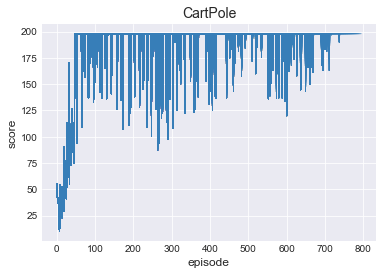

In [13]:
agent = Agent()
agent.train()

In [25]:
# Render an episode and save as a GIF file
from PIL import Image
import numpy as np

# 
# action = self.env.action_space.sample()
# screen, reward, terminal, info = self.env.step(action)

def render_episode(env: gym.Env, model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  env.reset()
  action = env.action_space.sample()
  state, reward, terminal, info = env.step(action)
  
  for i in range(1, max_steps + 1):
    action_probs = model(torch.FloatTensor(state).to(device))
    action = np.argmax(np.squeeze(action_probs.cpu().detach().numpy()))

    state, _, done, _ = env.step(action)

    # Render screen every 10 steps
    if i % 2 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images


# Save GIF image
images = render_episode(agent.env, agent.policy_network.pi, 20000)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

In [26]:
images

[<PIL.Image.Image image mode=RGB size=600x400 at 0x1681A3BF8C8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x16810327BC8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x168100D4688>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x1681A4FC308>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x1681A3BF508>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x16810483248>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x168100E01C8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x16810364748>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x16810364388>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x16810364DC8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x1681165FCC8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x168103641C8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x1681044B3C8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x1681044B1C8>,
 <PIL.Image.Image image mode=RGB size=600x400 at 0x1681044B2C8>,
 <PIL.Image.Image image m